In [2]:
import pandas as pd

projects1 = pd.read_csv('kickstarter-projects/ks-projects-201801.csv')
projects1

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


In [65]:
import numpy as np
import matplotlib.pyplot as plt

def summarize(df):
    n_failed = np.count_nonzero(df.state == 'failed')
    print("{} Failed".format(n_failed))
    n_success = np.count_nonzero(df.state == 'successful')
    print("{} Success".format(n_success))
    n_canceled = np.count_nonzero(df.state == 'canceled')
    print("{} Canceled".format(n_canceled))
    
def hist_by_group(df, groupname, n_groups=None):
    if n_groups is None:
        grouped = df.groupby(groupname)
        names = grouped.groups.keys()
    else:
        pcts = np.arange(0, 1, 1/(n_groups))
        quantiles = df[groupname].quantile(pcts)
        inds = np.digitize(df[groupname], quantiles)
        grouped = df.groupby(inds)
        names = []
        for a, b in zip(pcts, pcts[1:]):
            names.append('{}-{}'.format(quantiles[a], quantiles[b]))
        names.append('{}-{}'.format(quantiles[b], max(df[groupname])))
    
    num_groups = len(grouped)
    
    successes = []
    failures = []
    cancels = []

    margins = []
    totals = []
    
    for name, group in grouped:

        n_failed = np.count_nonzero(group.state == 'failed')
        n_success = np.count_nonzero(group.state == 'successful')
        n_canceled = np.count_nonzero(group.state == 'canceled')
        successes.append(float(n_success) / len(group))
        failures.append(float(n_failed) / len(group))
        cancels.append(float(n_canceled) / len(group))
        
        margins.append(np.abs(n_success - n_failed))
        totals.append(n_success + n_failed)
    
    bar_width = .25
    indices = np.arange(num_groups)
    
    plt.bar(indices, successes, bar_width, color='g', label='successes')
    plt.bar(indices + bar_width, failures, bar_width, color='r', label='failures')
    plt.bar(indices + bar_width * 2, cancels, bar_width, color='y', label='cancels')
    plt.xticks(indices + bar_width * 1.5, names)
    
    plt.title("{} Mean difference: {:.2f}".format(groupname, sum(margins)/sum(totals)))

197719 Failed
133956 Success
38779 Canceled


<IPython.core.display.Javascript object>


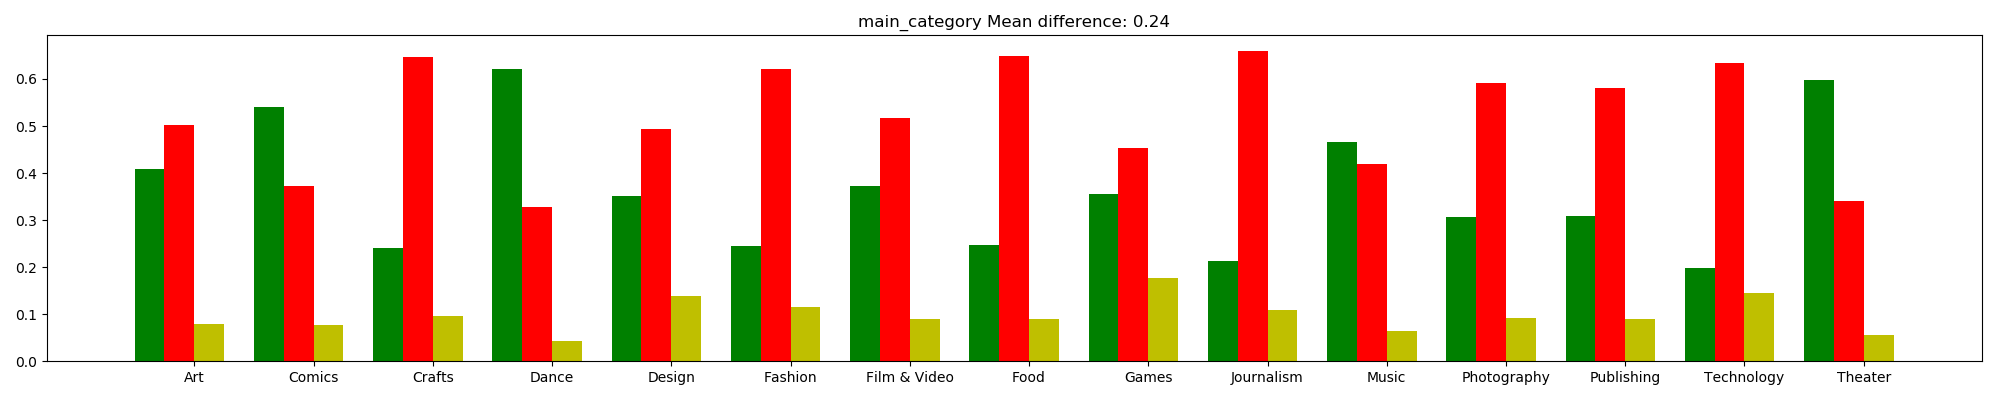

<IPython.core.display.Javascript object>


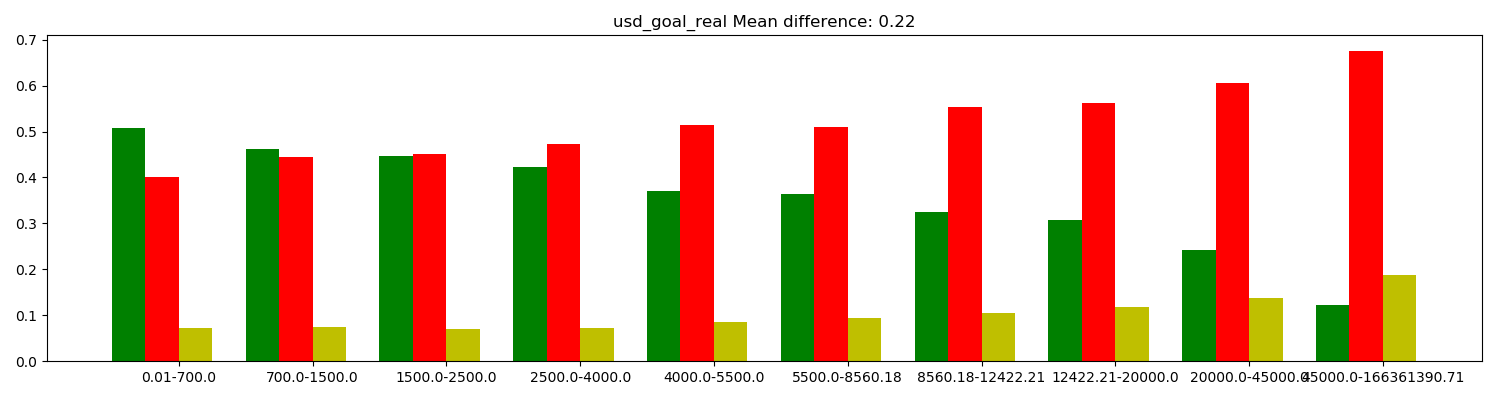

In [67]:
%matplotlib notebook

summarize(projects1)
plt.figure(figsize=(20, 4))
hist_by_group(projects1, 'main_category')
plt.tight_layout()
plt.figure(figsize=(15, 4))
hist_by_group(projects1, 'usd_goal_real', 10)
plt.tight_layout()
